In [95]:
# importing useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

Data taken from the Mice Protein Expression Data Set at UCI ML repo https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression


In [96]:
#downloading data
file_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls'
data_mice = pd.read_excel(file_path)


**Preprocessing of data**

In [97]:
display(data_mice)


,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,...,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,...,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.122652,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,...,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.116682,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,...,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.118508,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,...,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.132781,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,...,0.419095,0.393447,0.160200,0.768113,0.185718,1.645807,0.296829,0.309345,1.206995,0.164650,0.160687,0.188221,0.104784,0.141983,0.167710,0.136838,0.116048,0.255528,0.140871,0.48

In [98]:
#checking for null entries
data_mice.isnull().any()

MouseID      False
DYRK1A_N      True
ITSN1_N       True
BDNF_N        True
NR1_N         True
             ...  
CaNA_N       False
Genotype     False
Treatment    False
Behavior     False
class        False
Length: 82, dtype: bool

**Observation**  
There are many null entries in the dataset, we need to find a way to tackle these.

In [99]:
# checking data type and no. of unique values in each column
for col in data_mice.columns.values:
  list_vals = pd.unique(data_mice[col])
  print(col, ", type:", data_mice[col].dtypes, ", unique values:", len(list_vals))

MouseID , type: object , unique values: 1080
DYRK1A_N , type: float64 , unique values: 1078
ITSN1_N , type: float64 , unique values: 1077
BDNF_N , type: float64 , unique values: 1078
NR1_N , type: float64 , unique values: 1078
NR2A_N , type: float64 , unique values: 1078
pAKT_N , type: float64 , unique values: 1077
pBRAF_N , type: float64 , unique values: 1076
pCAMKII_N , type: float64 , unique values: 1078
pCREB_N , type: float64 , unique values: 1078
pELK_N , type: float64 , unique values: 1078
pERK_N , type: float64 , unique values: 1078
pJNK_N , type: float64 , unique values: 1077
PKCA_N , type: float64 , unique values: 1078
pMEK_N , type: float64 , unique values: 1078
pNR1_N , type: float64 , unique values: 1078
pNR2A_N , type: float64 , unique values: 1078
pNR2B_N , type: float64 , unique values: 1078
pPKCAB_N , type: float64 , unique values: 1078
pRSK_N , type: float64 , unique values: 1078
AKT_N , type: float64 , unique values: 1078
BRAF_N , type: float64 , unique values: 1078


**Observation**  
1. There are several columns which have oject as entries instead of float, these are string entries. We need to drop these columns for our purpose.
2. Every numeric features have multiple unique values, so that can be treates as continuous data.

In [100]:
#summary of data for each column
data_mice.describe()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,pNUMB_N,RAPTOR_N,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
count,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1062.000000,1077.000000,1077.000000,1077.000000,1073.000000,1077.000000,1077.000000,1077.000000,1062.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,867.000000,795.000000,1080.000000,1005.000000,1080.000000,900.000000,870.000000,810.000000,1080.000000
mean,0.425810,0.617102,0.319088,2.297269,3.843934,0.233168,0.181846,3.537109,0.212574,1.428682,0.545904,0.313505,0.317939,0.275033,0.825813,0.726933,1.561965,1.525338,0.442848,0.682236,0.378519,0.363357,0.180492,1.173400,2.474492,1.172603,0.241644,0.272789,0.693180,0.168417,0.404808,2.146550,0.542635,0.452459,0.415311,0.759047,0.585186,0.368370,0.565317,0.357095,0.315813,0.418605,0.394475,0.181080,0.943116,0.161211,1.706599,0.292434,0.429226,1.197420,0.216482,0.166631,0.179307,0.121521,0.156478,0.181300,0.210489,0.120889,0.221851,0.126560,0.527349,0.291276,1.548348,2.235236,0.159821,1.239270,0.848767,0.226676,0.157914,0.134762,0.121521,0.131053,0.446073,0.169609,0.183135,0.205440,1.337784
std,0.249362,0.251640,0.049383,0.347293,0.933100,0.041634,0.027042,1.295169,0.032587,0.466904,0.345309,0.051978,0.052236,0.046164,0.117969,0.188013,0.270737,0.481780,0.066672,0.127434,0.216388,0.052352,0.026370,0.335786,0.653397,0.244752,0.033901,0.041075,0.120825,0.028138,0.061173,0.435742,0.280568,0.065488,0.089290,0.122446,0.100601,0.062583,0.088201,0.063025,0.054163,0.067288,0.156170,0.029296,0.172838,0.019308,0.578442,0.037380,0.137440,0.361743,0.185309,0.031896,0.018826,0.014276,0.015071,0.024919,0.069010,0.013233,0.034886,0.026885,0.082057,0.030015,0.248132,0.254395,0.024150,0.173580,0.094311,0.028989,0.029537,0.027417,0.014276,0.023863,0.066432,0.059402,0.040406,0.055514,0.317126
min,0.145327,0.245359,0.115181,1.330831,1.737540,0.063236,0.064043,1.343998,0.112812,0.429032,0.149155,0.052110,0.191431,0.056818,0.500160,0.281285,0.301609,0.567840,0.095942,0.064421,0.143894,0.212960,0.113636,0.497695,1.131796,0.151124,0.046298,0.147201,0.198743,0.107394,0.235595,1.134886,0.217120,0.201143,0.227880,0.166579,0.155321,0.226409,0.184785,0.185598,0.194824,0.237777,0.131120,0.117999,0.344120,0.099976,0.598767,0.181157,0.130206,0.529108,0.052528,-0.062008,0.072326,0.067254,0.100217,0.099734,0.096233,0.086114,0.111382,0.072580,0.284001,0.207438,0.853176,1.206098,0.101233,0.750664,0.577397,0.155869,0.088305,0.080657,0.067254,0.085419,0.258626,0.079691,0.105537,0.101787,0.586479
25%,0.288121,0.473361,0.287444,2.057411,3.155678,0.205755,0.164595,2.479834,0.190823,1.203665,0.337405,0.281242,0.281829,0.244287,0.743491,0.590303,1.381288,1.168258,0.404144,0.596816,0.264334,0.330859,0.161830,0.944435,1.991756,1.023134,0.220400,0.247096,0.617074,0.149622,0.366339,1.826707,0.319639,0.410389,0.351992,0.683501,0.530881,0.326621,0.514892,0.312766,0.276127,0.371976,0.281090,0.

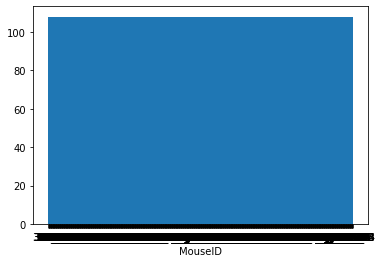

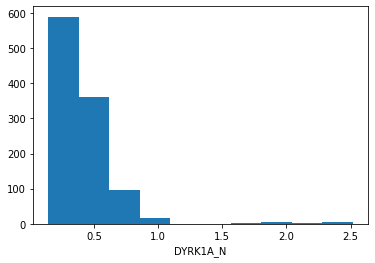

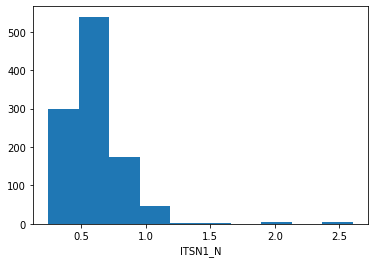

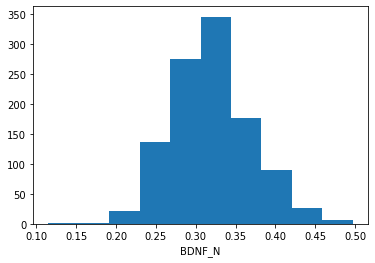

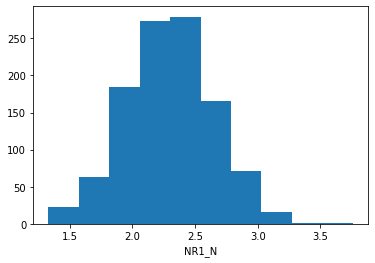

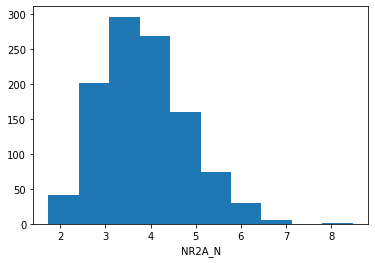

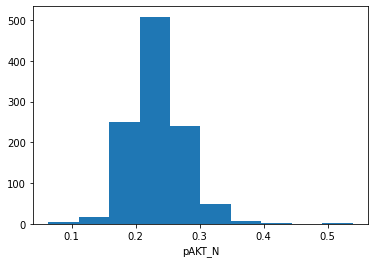

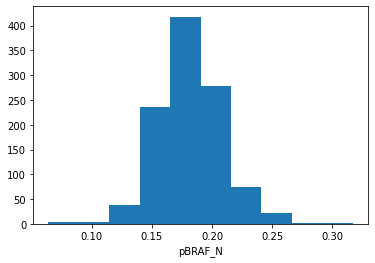

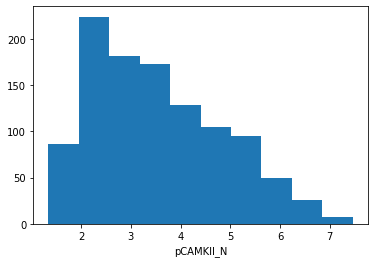

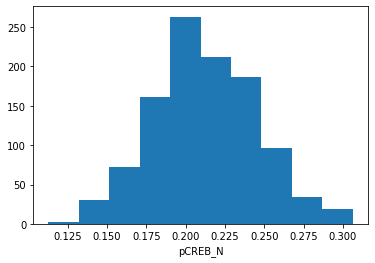

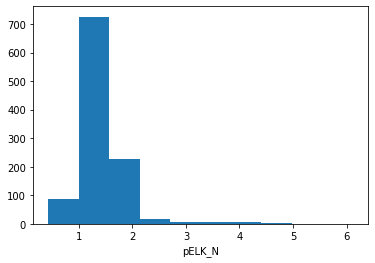

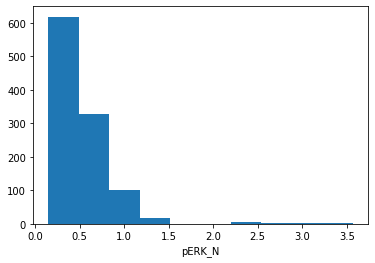

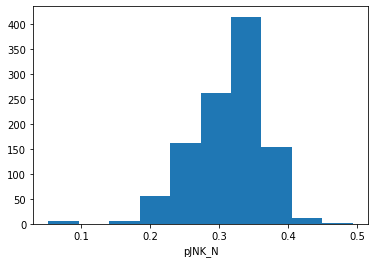

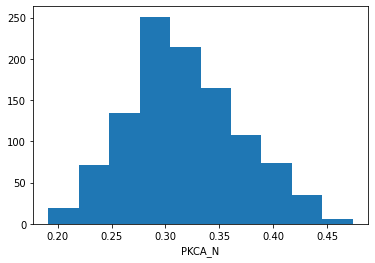

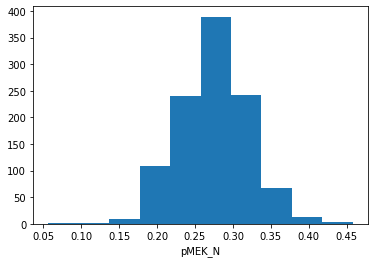

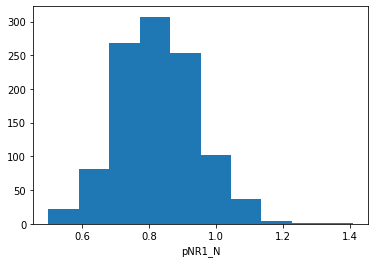

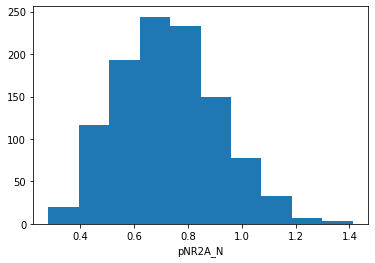

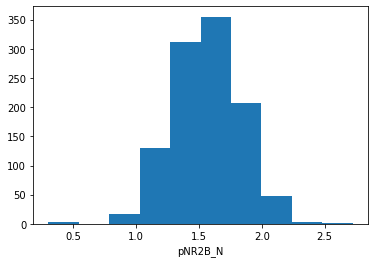

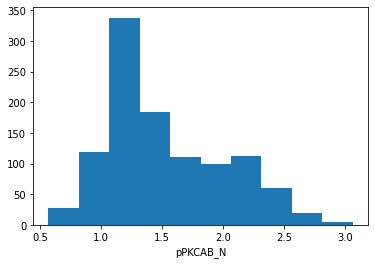

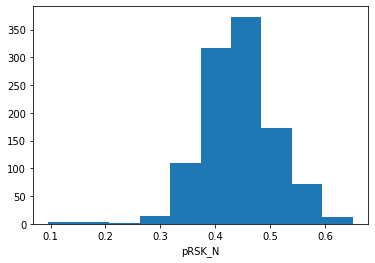

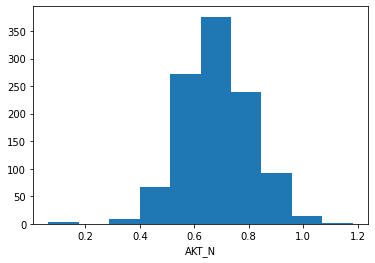

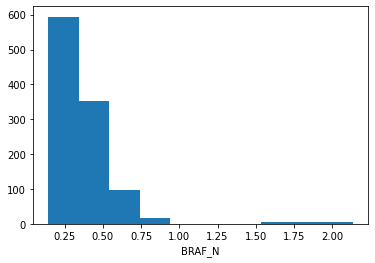

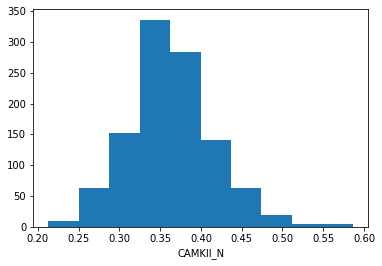

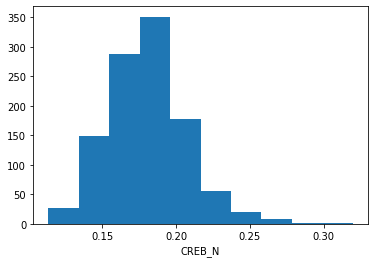

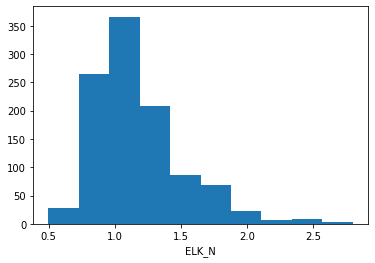

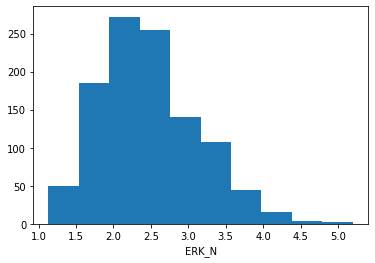

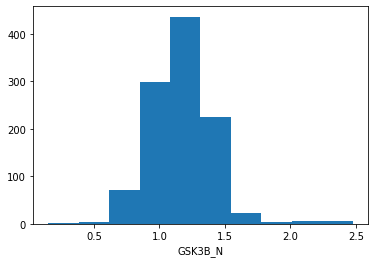

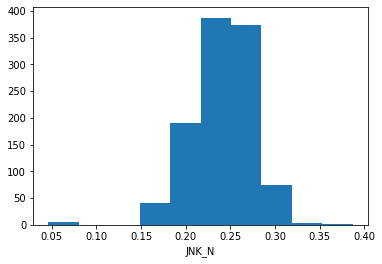

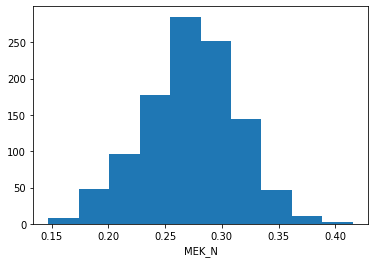

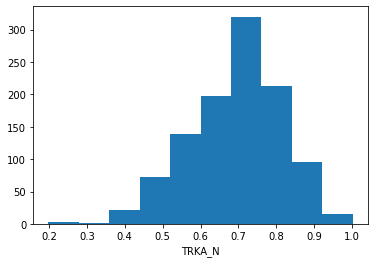

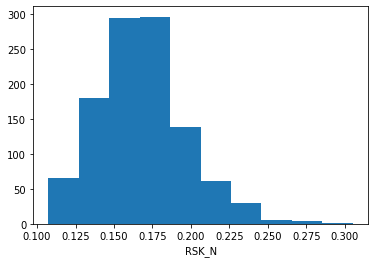

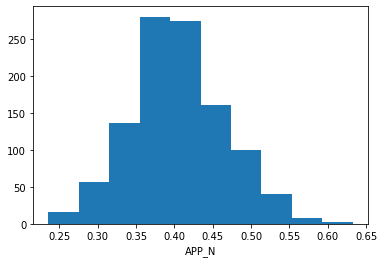

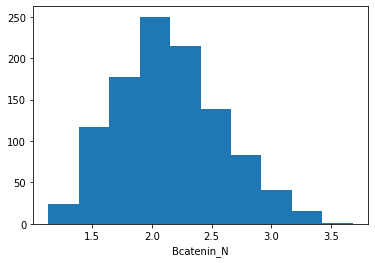

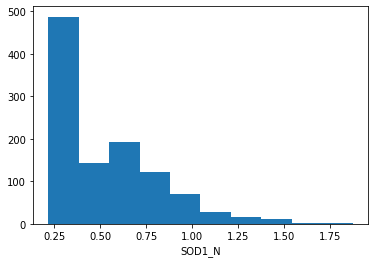

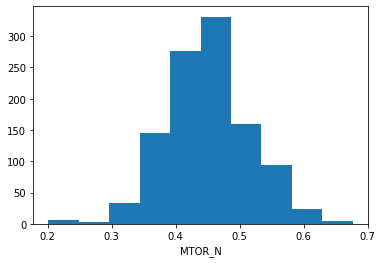

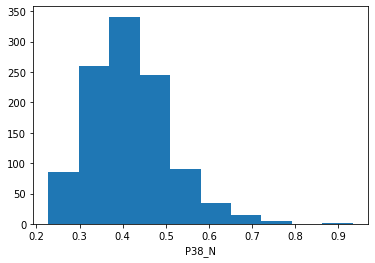

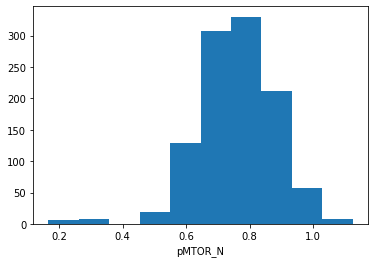

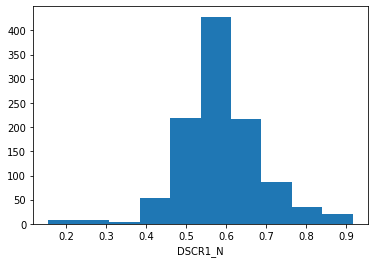

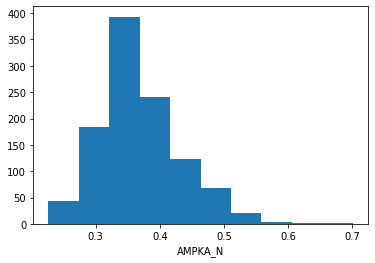

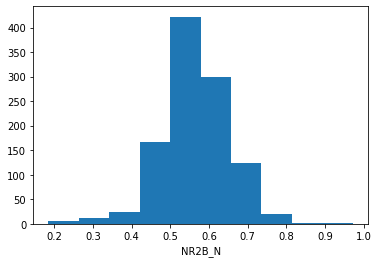

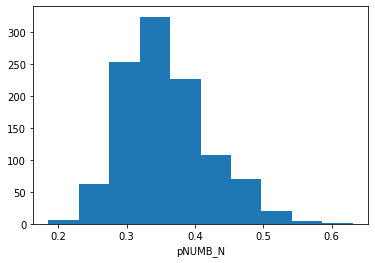

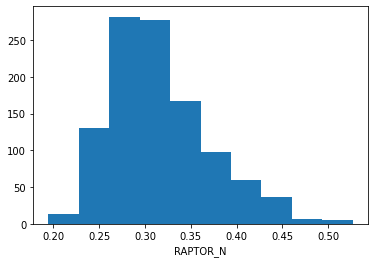

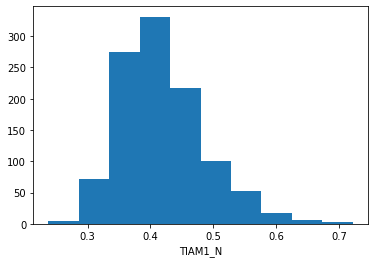

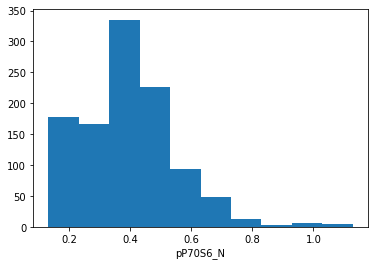

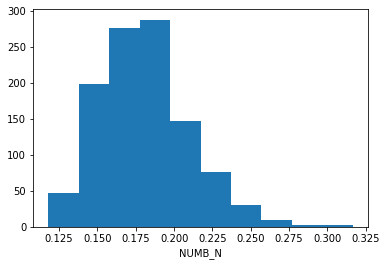

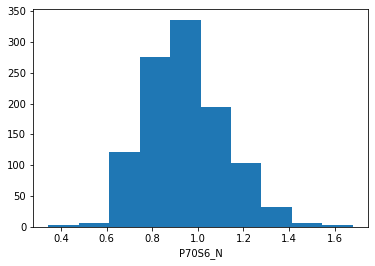

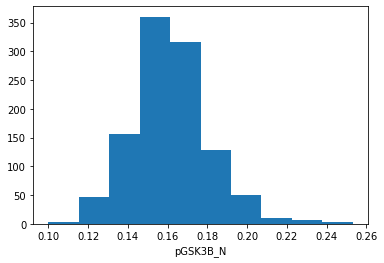

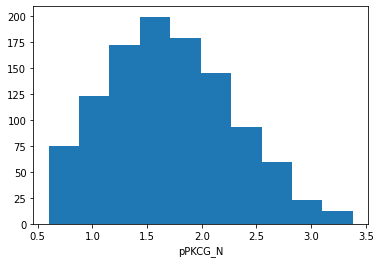

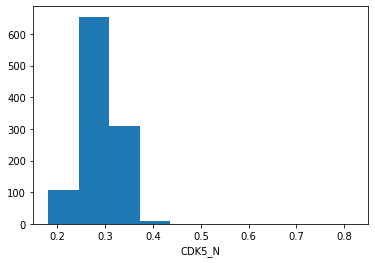

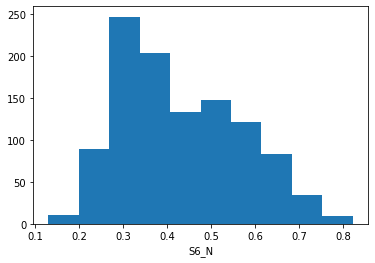

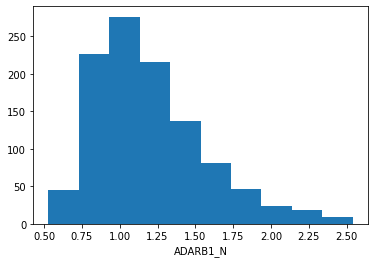

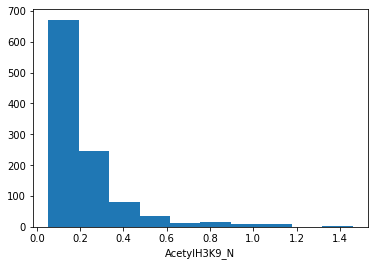

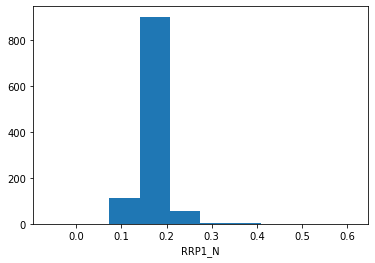

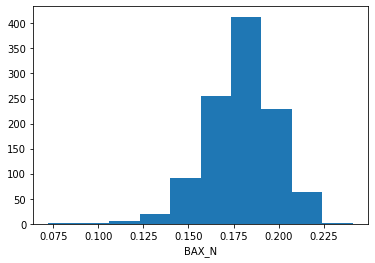

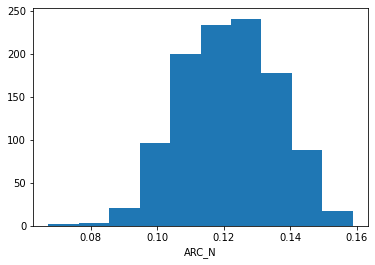

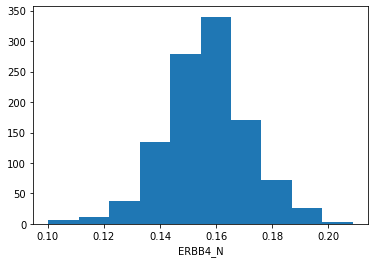

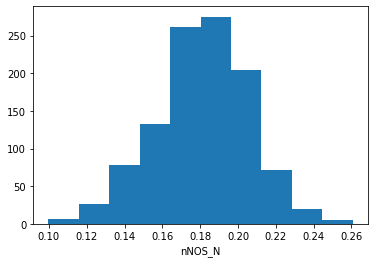

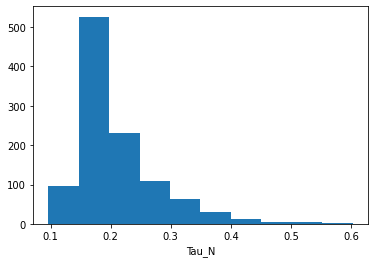

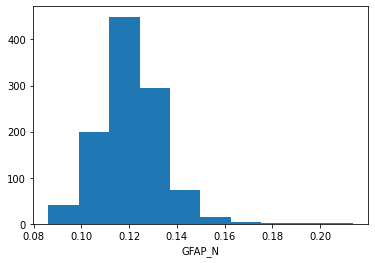

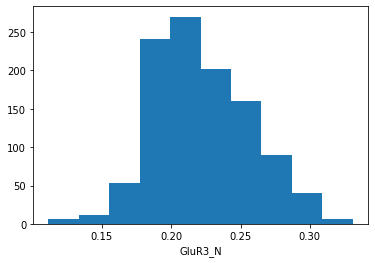

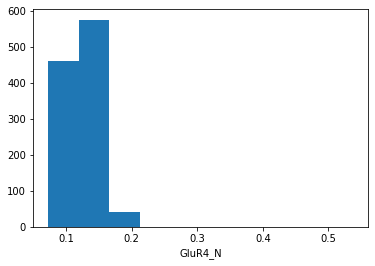

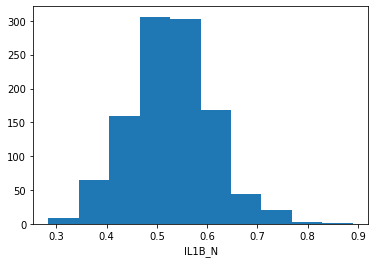

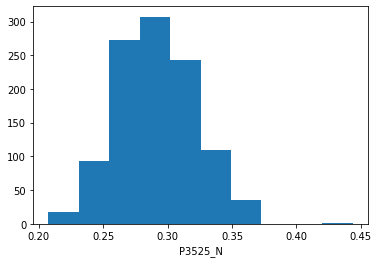

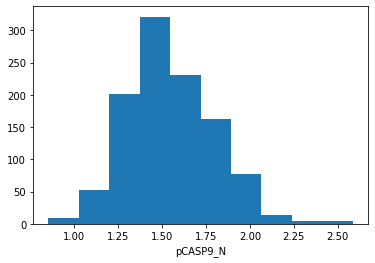

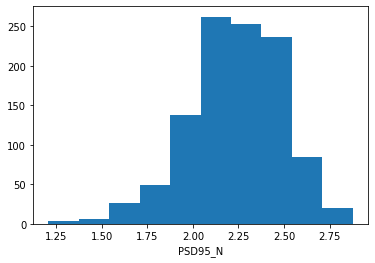

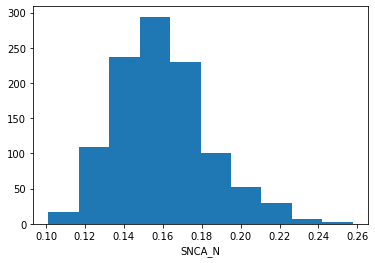

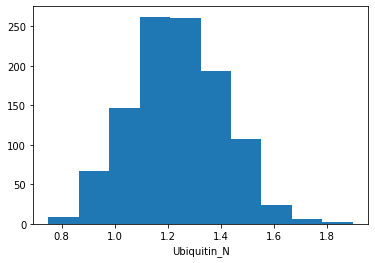

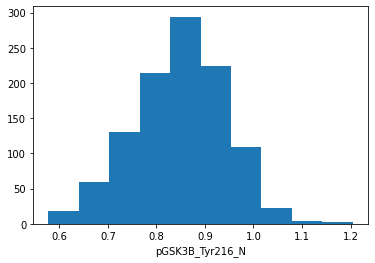

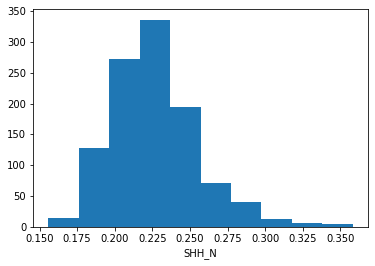

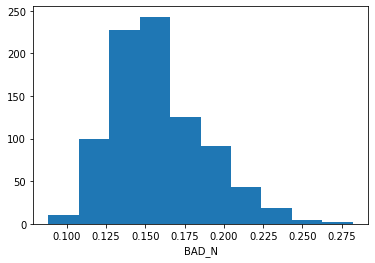

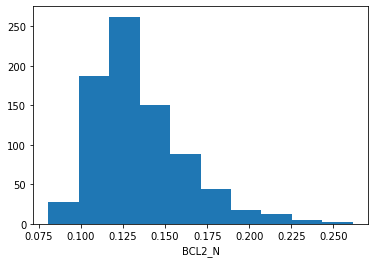

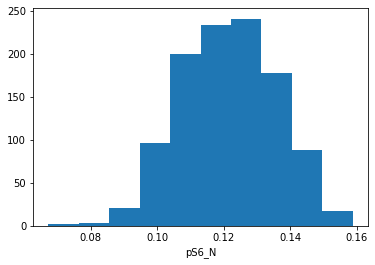

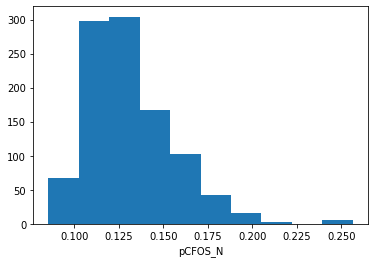

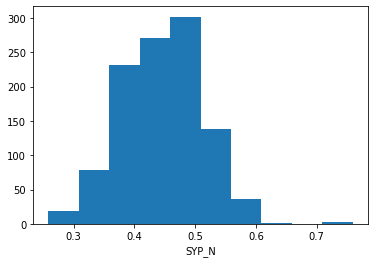

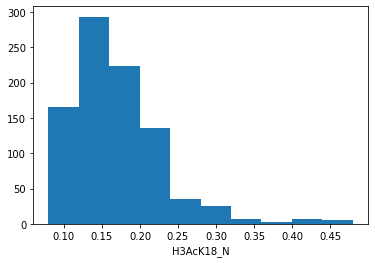

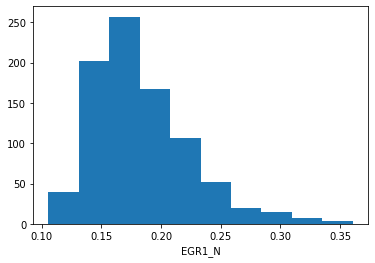

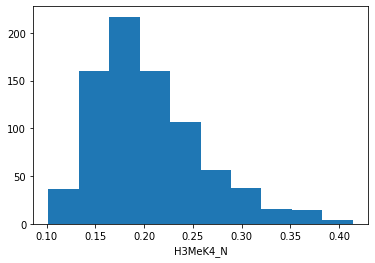

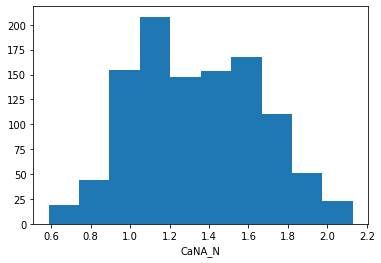

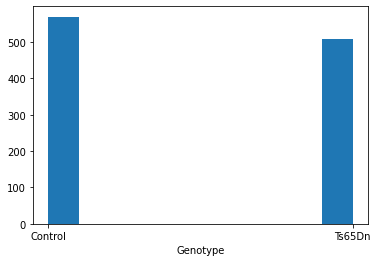

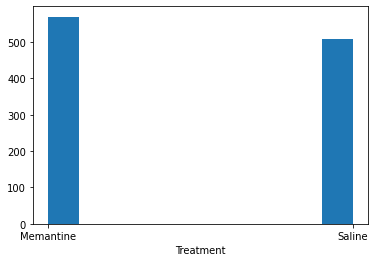

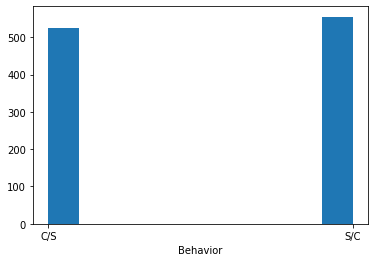

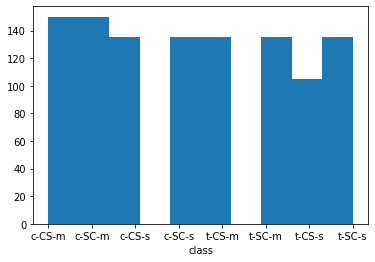

In [101]:
#histogram of values in each feature
for col in data_mice.columns.values:
  plt.hist(data_mice[col])
  plt.xlabel(col)
  plt.show()

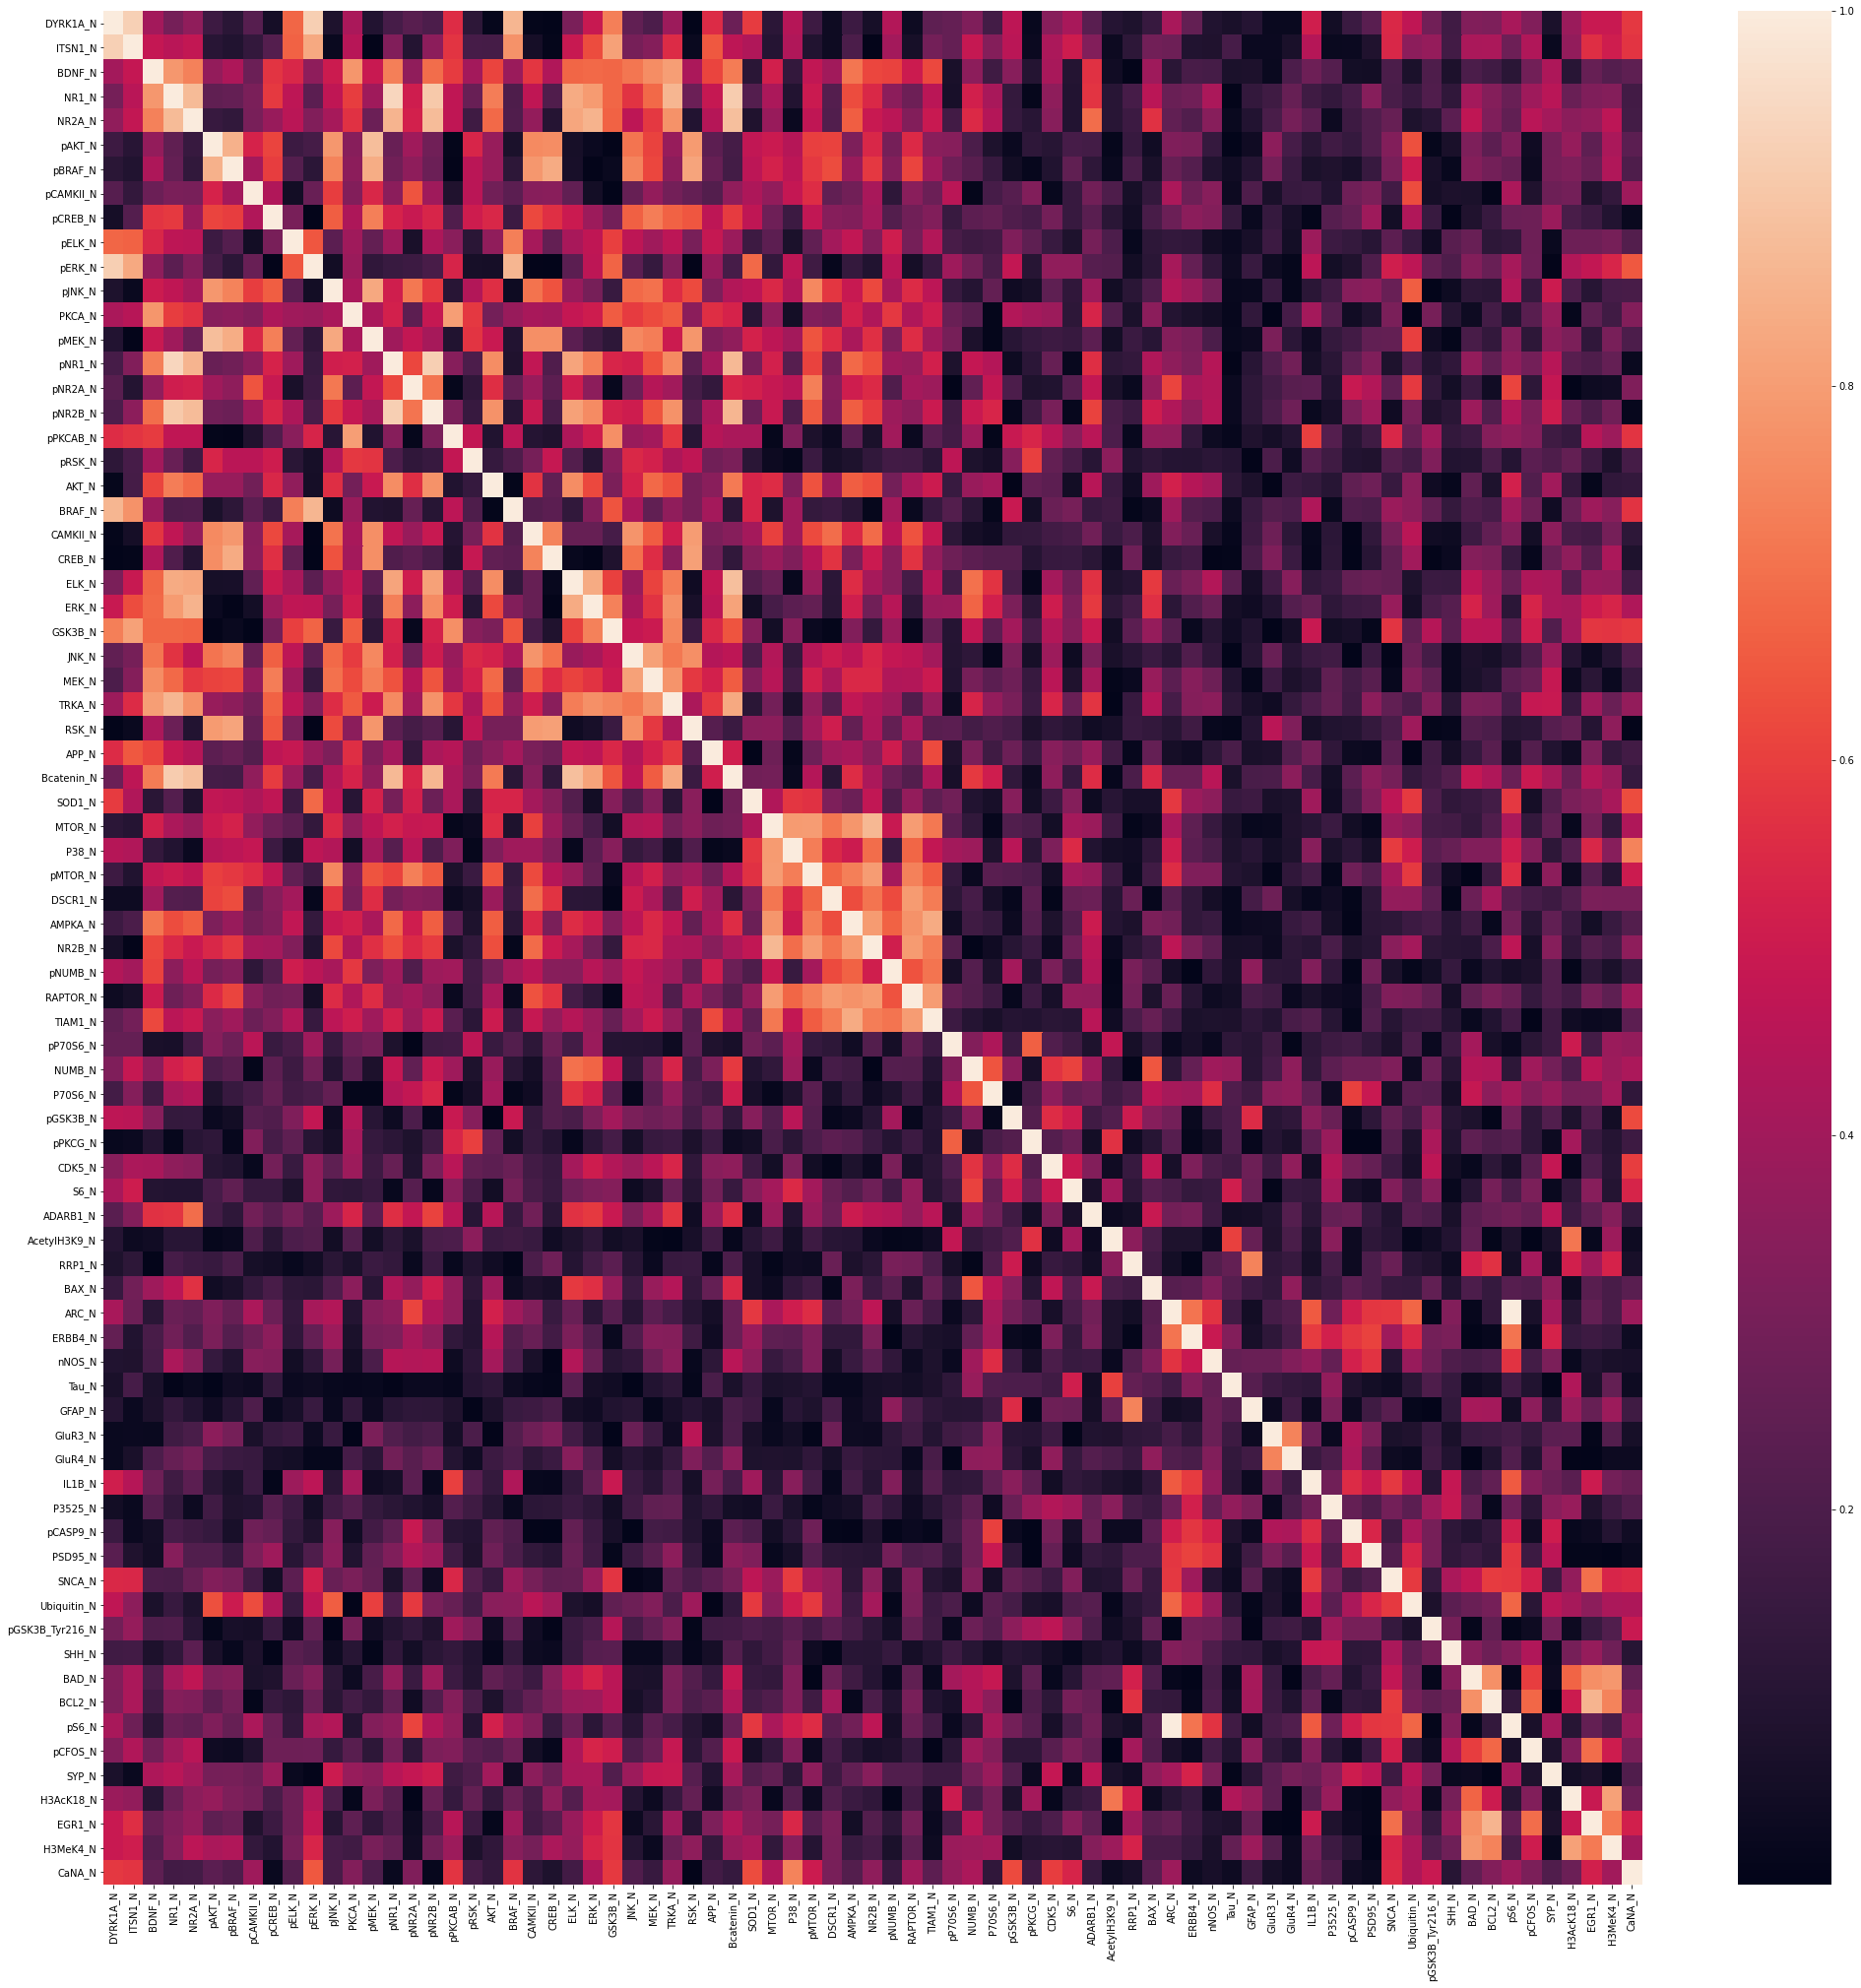

In [102]:
#correlation matrix plot 
corr_matrix = data_mice.corr(method = "spearman") #spearman for non linear


fig, ax = plt.subplots(figsize = (35,35))
sns.heatmap(abs(corr_matrix), annot = False)
plt.show()

**Observation**  
From the correlation heatmap plotted above, we can see that there are several pair of entries which are highly correlated, we will drop one of the feature from the pairs which are highly correlated.

In [103]:
# conveting genotype entry to int values as our models can work with numeric values only
data_mice.Genotype[data_mice.Genotype == 'Control'] = 1
data_mice.Genotype[data_mice.Genotype == 'Ts65Dn'] = 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [117]:
#prediction of genotype using other features, separating data into X and y and dropping string entries and correlated features
y = data_mice.Genotype
X = data_mice.drop(["MouseID", "Genotype", "Treatment", "Behavior", "class", "pNR1_N", "ARC_N"], axis=1)
#print(y)

In [ ]:
#multivariate imputation

imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X)

X = imp.transform(X)

In [106]:
X_df = pd.DataFrame(X)
X_df.isnull().any()


0     False
1     False
2     False
3     False
4     False
      ...  
70    False
71    False
72    False
73    False
74    False
Length: 75, dtype: bool

In [107]:
for col in X_df.columns.values:
  list_vals = pd.unique(X_df[col])
  print(col, ", type:", X_df[col].dtypes, ", unique values:", len(list_vals))

0 , type: float64 , unique values: 1080
1 , type: float64 , unique values: 1079
2 , type: float64 , unique values: 1080
3 , type: float64 , unique values: 1080
4 , type: float64 , unique values: 1080
5 , type: float64 , unique values: 1079
6 , type: float64 , unique values: 1078
7 , type: float64 , unique values: 1080
8 , type: float64 , unique values: 1080
9 , type: float64 , unique values: 1080
10 , type: float64 , unique values: 1080
11 , type: float64 , unique values: 1079
12 , type: float64 , unique values: 1080
13 , type: float64 , unique values: 1080
14 , type: float64 , unique values: 1080
15 , type: float64 , unique values: 1080
16 , type: float64 , unique values: 1080
17 , type: float64 , unique values: 1080
18 , type: float64 , unique values: 1080
19 , type: float64 , unique values: 1080
20 , type: float64 , unique values: 1080
21 , type: float64 , unique values: 1076
22 , type: float64 , unique values: 1080
23 , type: float64 , unique values: 1080
24 , type: float64 , uniqu

**Observation**  
1. After imputation, now there are no more missing entries in the data.
2. Also string values and correlated values are removed

In [108]:
#preprocessing
scaler = preprocessing.StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [109]:
#lasso regression 

hyperparameters = {'alpha':[0.001,0.002,0.005,0.01, 0.02, 0.05]}

lasso = GridSearchCV(estimator=Lasso(), param_grid =hyperparameters,cv=10)
lasso.fit(np.array(X_train), np.squeeze(y_train))

print(lasso.best_params_)

{'alpha': 0.002}


In [110]:
lasso_model = Lasso(alpha = 0.002).fit(X_train, y_train)

print("training score:",lasso_model.score(X_train, y_train))
print("test score:", lasso_model.score(np.array(X_test), np.array(y_test)))


training score: 0.8119113510987425
test score: 0.7601311860503092


In [111]:
print(lasso_model.coef_)

[-0.00000000e+00  3.26509843e-01 -2.44128674e-03 -1.27576688e-01
 -1.34468638e-02  5.26473099e-02 -0.00000000e+00 -0.00000000e+00
  6.57202283e-02 -0.00000000e+00 -0.00000000e+00 -5.52578077e-03
  0.00000000e+00 -1.75351855e-02 -7.53848259e-02  1.00650184e-01
 -1.05159776e-01 -3.34184133e-02  4.34023427e-02 -2.56897594e-01
 -6.60910419e-02 -1.80513232e-02 -1.13411147e-01 -1.68875162e-01
 -1.57766922e-02 -0.00000000e+00  2.53919680e-02  1.14372652e-01
 -3.58356438e-02  2.43806545e-01 -0.00000000e+00  2.57172386e-02
 -9.05829496e-02 -2.60361034e-02 -2.88545547e-04  9.25283673e-02
 -1.07177032e-01 -5.64272274e-02 -5.23667144e-02 -2.62780098e-03
  1.41576725e-01  4.05693740e-02  5.90725249e-02 -0.00000000e+00
  4.02583637e-02  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  5.46592443e-03 -0.00000000e+00 -5.63191823e-03  0.00000000e+00
  8.54454526e-02  6.31700849e-04  1.80627343e-02  0.00000000e+00
 -8.21624762e-02  8.61024286e-05 -4.68918287e-02  2.61206880e-02
  3.20118689e-02 -0.00000

In [112]:
k = 0
for val in lasso_model.coef_:
  if val == 0:
    k+=1

print(" number of features eliminated =",k)

 number of features eliminated = 20


In [113]:
# random forest
pipeline = make_pipeline(RandomForestRegressor(n_estimators=100))

hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}

rf = GridSearchCV(pipeline, hyperparameters, cv=10)
rf.fit(np.array(X_train), np.array(y_train))
print(rf.best_params_)

{'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'sqrt'}


In [114]:
rf = RandomForestRegressor(max_depth=None, max_features='sqrt')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('Test r2 score :',r2_score(y_test,y_pred))

Test r2 score : 0.8446811283546257


In [120]:
#ridge regression

hyperparameters = {'alpha':[0.001,0.002,0.005,0.01, 0.02, 0.05]}

ridge = GridSearchCV(estimator=Ridge(), param_grid =hyperparameters,cv=10)
ridge.fit(np.array(X_train), np.squeeze(y_train))

print(ridge.best_params_)

{'alpha': 0.05}


In [121]:
ridge_model = Ridge(alpha = 0.05).fit(X_train, y_train)

print("training score:",ridge_model.score(X_train, y_train))
print("test score:", ridge_model.score(np.array(X_test), np.array(y_test)))

training score: 0.8231123179484348
test score: 0.7616648129169935
